# Milestone Project: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset we'll be using) is available here:

*https://arxiv.org/abs/1710.06071*

And reading through the paper above, we see that the model architecture that they used to achieve their best results is available here:

*https://arxiv.org/abs/1612.05251*

In [ ]:
## Confirm access to a GPU
!nvidia-smi

Tue Jan 31 01:14:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get the data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's GitHub:

*https://github.com/Franck-Dernoncourt/pubmed-rct*

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 9.72 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed 20k dataset (start smaller than actual 200k)
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replace by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all the filenames in target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data

Now we've got some text data, it's time to take a closer look at it...

And one of the best ways to become one with the data it to **visualize it**.

With that in mind, let's write a function to read in all of the lines of a target text file.

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """ Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath

    Returns:
      A list of strings with on string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

It may be to our benefit to format it like this:
```
[{'line_number':0,
  'target': BACKGROUND,
  'text': "[input text here]\n",
  'total lines: 11'},
  {...},
   ...
]
```

In [ ]:
# Read in train, test, and dev.txt to the above format with a custom function
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries containing abstract line data.

  Takes in a filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence, how many
  sentences are in the current abstract and what sentence number the target
  line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line ine filename
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split into new lines

      # Iterate through each line in a single abstract and count them at same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split label from text
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number # what number line does it appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in target abstract? (start from zero)
        abstract_samples.append(line_data)# add line data to abstract samples list

    else: # line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # same for val set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 401 ms, sys: 65.2 ms, total: 466 ms
Wall time: 466 ms


In [ ]:
# Check first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

How that our data is in a list of dictionaries, how about we turn it into a pandas DF to further visualize it?

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data(?)
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

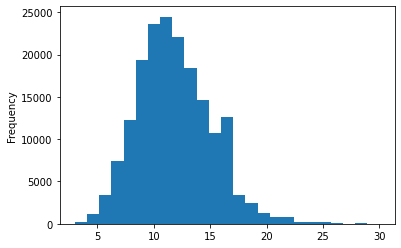

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist(bins=25);

### Get list of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Turning our labels into numbers

In [ ]:
# One-hot encode labels
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target") and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
len(train_labels_encoded)

180040

In [ ]:
# Get class names and number of classes from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a Series of Modelling Experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And, as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

### Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall, and F1). Rather than writing it all over again, let's just import it from here:

https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-31 01:16:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-31 01:16:25 (103 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our text for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sentence_len = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sentence_len)
avg_sentence_len

26.338269273494777

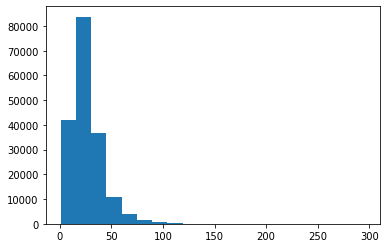

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sentence_len, bins=20);

A large majority falls near the sentence_len = 25 mark.

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sentence_len, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set?
max(sentence_len)

296

## Create a Text Vectorization Layer 

In [ ]:
# How many unique values are in our vocab? (taken from Table 2 in our main paper)
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
this was a randomized , single-dose , open-label , two-way crossover study evaluating pharmacokinetic parameters of @ and @ mg dosages of zst in elderly subjects ( n = @ ) , and @ mg dosages of zst in non-elderly subjects ( n = @ ) .

Length of text: 47

Vectorized text: [[   23    10     8    29  2744   570  5100   484    17  1556  1315   315
      4     3    68  4494     4 15241     5   836   104    40     3    68
   4494     4 15241     5  8399   104    40     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocab?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [ ]:
# Create an embedding layer
token_embed = tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                      output_dim=128,
                                      mask_zero=True,
                                      name="token_embedding")

In [ ]:
# Show an example embedding
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedding sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 this was a randomized , single-dose , open-label , two-way crossover study evaluating pharmacokinetic parameters of @ and @ mg dosages of zst in elderly subjects ( n = @ ) , and @ mg dosages of zst in non-elderly subjects ( n = @ ) .
Sentence after vectorization (before embedding):
 [[   23    10     8    29  2744   570  5100   484    17  1556  1315   315
      4     3    68  4494     4 15241     5   836   104    40     3    68
   4494     4 15241     5  8399   104    40     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.02211337  0.0005553   0.00761538 ... -0.03772583  0.01454296
   -0.04103252]
  [ 0.01739016 -0.0287939   0.02362437 ... -0.0298457   0.04147631
   -0.04260926]
  [-0.00862242 -0.01592533  0.0065661  ...  0.04853288 -0.02118669
   -0.00672243]
  ...
  [ 0.02977462 -0.03005368 -0.04020802 ...  0.04626952 -0.0

## Creating dataset (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API. Many of the steps here are discussed at length in the following documentation links:

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                    train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                     val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,
                                                   test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
# Take the TensorSliceDatasets and turn them into prefetch datasets 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D Model

In [ ]:
# Make a Conv1D model to try and beat our baseline
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,
                  kernel_size=5,
                  padding="same",
                  activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset, epochs=5,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 12s 9ms/step - loss: 0.9256 - accuracy: 0.6294 - val_loss: 0.6984 - val_accuracy: 0.7330
Epoch 2/5
562/562 [==============================] - 5s 8ms/step - loss: 0.6675 - accuracy: 0.7505 - val_loss: 0.6442 - val_accuracy: 0.7673
Epoch 3/5
562/562 [==============================] - 5s 8ms/step - loss: 0.6244 - accuracy: 0.7704 - val_loss: 0.6030 - val_accuracy: 0.7822
Epoch 4/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5933 - accuracy: 0.7871 - val_loss: 0.5835 - val_accuracy: 0.7842
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5941 - accuracy: 0.7913 - val_loss: 0.5630 - val_accuracy: 0.7945


In [ ]:
# Evaluate on whole validation set
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5629 - accuracy: 0.7996


[0.5629054307937622, 0.7996160387992859]

In [ ]:
# Make predictions (array of probabilities)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[5.48254788e-01, 1.61890075e-01, 3.21127884e-02, 2.08954275e-01,
         4.87880707e-02],
        [4.12635088e-01, 3.74594688e-01, 2.20255740e-02, 1.48476496e-01,
         4.22680974e-02],
        [1.84127972e-01, 3.80390882e-03, 1.27806794e-03, 8.10747504e-01,
         4.25182843e-05],
        ...,
        [5.29042845e-05, 6.62251492e-04, 4.64577787e-03, 5.02413786e-05,
         9.94588852e-01],
        [1.05113201e-01, 2.79272944e-01, 1.19808786e-01, 7.83557966e-02,
         4.17449266e-01],
        [1.69596002e-01, 7.24237502e-01, 6.06811941e-02, 2.04100981e-02,
         2.50752009e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred_probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 79.96160466039984,
 'precision': 0.7993939897137999,
 'recall': 0.7996160466039984,
 'f1': 0.796538800948781}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature Extraction w/ Pretrained Token Embeddings

Now let's use pretrained word embedding from TensorFlow Hub. More specifically, the Universal Sentence Encoder (*USE*):

https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings. However, we're going to stick with the latest created using USE pretrained embeddings.

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                         trainable=False,
                                                         name="universal_sentence_encoder")

In [ ]:
# Test out on random sentence
random_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:25]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 overall survival analysis was performed on an intention-to-treat basis , retaining patients in their randomized groups , and adjusting the overall treatment effect by known prognostic variables as well as the start time of chemotherapy .
Sentence after embedding:
 [-0.04692627 -0.04077936 -0.06106015 -0.04758443  0.00401929 -0.07380389
  0.02700712  0.00219103  0.02541012  0.05929916  0.0868587  -0.05421372
 -0.00358616  0.03235011 -0.00244538  0.01909965 -0.0871879   0.00163902
 -0.07089388  0.02575941 -0.03678653  0.08091816 -0.00297633 -0.00405072
 -0.00320003]

Length of sentence embedding: 512


In [ ]:
## Build and fit feature extraction model from TF Hub
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="use_feature_extraction_model")

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "use_feature_extraction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model 2
history_model_2 = model_2.fit(train_dataset, 
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 9s 13ms/step - loss: 0.9146 - accuracy: 0.6531 - val_loss: 0.7942 - val_accuracy: 0.6932
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7670 - accuracy: 0.7035 - val_loss: 0.7535 - val_accuracy: 0.7074
Epoch 3/5
562/562 [==============================] - 11s 20ms/step - loss: 0.7515 - accuracy: 0.7112 - val_loss: 0.7387 - val_accuracy: 0.7128
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7182 - accuracy: 0.7233 - val_loss: 0.7112 - val_accuracy: 0.7307
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7274 - accuracy: 0.7219 - val_loss: 0.6916 - val_accuracy: 0.7360


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.6998 - accuracy: 0.7343


[0.6997602581977844, 0.7342777848243713]

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[6.27747536e-01, 2.42630601e-01, 2.49917735e-03, 1.19610734e-01,
        7.51194730e-03],
       [4.55560684e-01, 4.46257025e-01, 4.17026365e-03, 9.16964561e-02,
        2.31549679e-03],
       [3.89840275e-01, 6.39052615e-02, 5.38658202e-02, 4.52008128e-01,
        4.03804928e-02],
       ...,
       [1.69705739e-03, 2.04693666e-03, 1.09223276e-01, 6.71885500e-04,
        8.86360884e-01],
       [2.51286617e-03, 2.22075786e-02, 5.09968638e-01, 7.95909669e-04,
        4.64515030e-01],
       [1.76668867e-01, 4.04362708e-01, 3.76658946e-01, 2.70223874e-03,
        3.96072492e-02]], dtype=float32)

In [ ]:
# Convert preds
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 1])>

In [ ]:
# Calculate results for pretrained embedding model
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 73.42777704223488,
 'precision': 0.7301318398721479,
 'recall': 0.7342777704223488,
 'f1': 0.7283508939876567}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D w/ Character Embeddings

The paper we're replicating states they used a combination of token- and character-level embeddings.

Previously, we've used token-leve embeddings, but we'll need to do some similar steps for characters if we want to use char-level embeddings.

### Creating a char-level tokenizer

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# Create a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_sentence)

'o v e r a l l   s u r v i v a l   a n a l y s i s   w a s   p e r f o r m e d   o n   a n   i n t e n t i o n - t o - t r e a t   b a s i s   ,   r e t a i n i n g   p a t i e n t s   i n   t h e i r   r a n d o m i z e d   g r o u p s   ,   a n d   a d j u s t i n g   t h e   o v e r a l l   t r e a t m e n t   e f f e c t   b y   k n o w n   p r o g n o s t i c   v a r i a b l e s   a s   w e l l   a s   t h e   s t a r t   t i m e   o f   c h e m o t h e r a p y   .'

In [ ]:
# Split sequence-level data splits into char-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

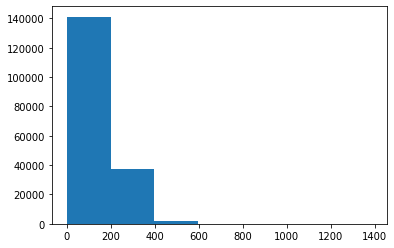

In [ ]:
# Check distribution of sequences at the character level
import matplotlib.pyplot as plt
plt.hist(char_len, bins=7);

In [ ]:
# What character length covers 95% of sequences?
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters with Python
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and [OOV/UNK] tokens
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training chars
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


Could turn standardization to "None" above if you want to leave punctuation in the vocabulary.

In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")

vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 w e   c o n d u c t e d   a n   o b s e r v a t i o n a l   c o h o r t   s t u d y   b a s e d   o n   t h e   n a t i o n w i d e   d a n i s h   r h e u m a t o l o g i c   d a t a b a s e   (   d a n b i o   )   a n d   c e n t e r   f o r   r h e u m a t o l o g y   r e s e a r c h   (   i c e b i o   )   r e g i s t r i e s   .

Length of random_train_chars: 143

Vectorized chars:
 [[20  2 11  7  6 10 16 11  3  2 10  5  6  7 22  9  2  8 21  5  3  4  7  6
   5 12 11  7 13  7  8  3  9  3 16 10 19 22  5  9  2 10  7  6  3 13  2  6
   5  3  4  7  6 20  4 10  2 10  5  6  4  9 13  8 13  2 16 15  5  3  7 12
   7 18  4 11 10  5  3  5 22  5  9  2 10  5  6 22  4  7  5  6 10 11  2  6
   3  2  8 17  7  8  8 13  2 16 15  5  3  7 12  7 18 19  8  2  9  2  5  8
  11 13  4 11  2 22  4  7  8  2 18  4  9  3  8  4  2  9  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0


In [ ]:
# Create a character level embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                                    output_dim=25,
                                    mask_zero=True,
                                    name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars after vectorization and embedding:\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 w e   c o n d u c t e d   a n   o b s e r v a t i o n a l   c o h o r t   s t u d y   b a s e d   o n   t h e   n a t i o n w i d e   d a n i s h   r h e u m a t o l o g i c   d a t a b a s e   (   d a n b i o   )   a n d   c e n t e r   f o r   r h e u m a t o l o g y   r e s e a r c h   (   i c e b i o   )   r e g i s t r i e s   .

Embedded chars after vectorization and embedding:
 [[[ 0.02170594 -0.03852103  0.01540163 ...  0.04837709 -0.00645953
    0.01509276]
  [ 0.00793948  0.04547671 -0.02972379 ...  0.04253212 -0.01340196
   -0.04454576]
  [-0.01219424 -0.02269282  0.01247698 ...  0.04159487  0.03813976
   -0.03697586]
  ...
  [-0.04519046 -0.01136655  0.04103113 ... -0.01534834  0.02985627
    0.02780968]
  [-0.04519046 -0.01136655  0.04103113 ... -0.01534834  0.02985627
    0.02780968]
  [-0.04519046 -0.01136655  0.04103113 ... -0.01534834  0.02985627
    0.02780968]]]

Character embedding shape: (1, 290, 25)


## Model 3: Conv1D Character-Level Embedding Model

In [ ]:
# Build a Conv1D model for character-level embeddings
inputs = layers.Input(shape=(1,), dtype=tf.string)
vectorizer = char_vectorizer(inputs)
embeddings = char_embed(vectorizer)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding="same",
                  activation="relu")(embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs= layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embed")

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_conv1d_char_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)   

In [ ]:
# Create char-level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset, epochs=5,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 1.2469 - accuracy: 0.4988 - val_loss: 1.0276 - val_accuracy: 0.5961
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9948 - accuracy: 0.6017 - val_loss: 0.9290 - val_accuracy: 0.6303
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9205 - accuracy: 0.6377 - val_loss: 0.8651 - val_accuracy: 0.6602
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8715 - accuracy: 0.6605 - val_loss: 0.8403 - val_accuracy: 0.6666
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8550 - accuracy: 0.6686 - val_loss: 0.8210 - val_accuracy: 0.6868


In [ ]:
# Make predictions with character model only
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8304 - accuracy: 0.6809


[0.8304169178009033, 0.6809214949607849]

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.27677837, 0.53340554, 0.05015855, 0.11829024, 0.02136724],
       [0.19431975, 0.64060366, 0.00352542, 0.14195132, 0.01959988],
       [0.22281583, 0.34238327, 0.04778352, 0.3558272 , 0.03119018],
       ...,
       [0.01315425, 0.03926281, 0.11203383, 0.02051803, 0.8150311 ],
       [0.01237433, 0.05709202, 0.40402153, 0.01431333, 0.51219875],
       [0.37265128, 0.48694175, 0.0764553 , 0.05735112, 0.00660056]],
      dtype=float32)

In [ ]:
# Convert preds
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 68.09214881504037,
 'precision': 0.6859677940130536,
 'recall': 0.6809214881504038,
 'f1': 0.678249331489978}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Pretrained Token Embeddings + Character Embeddings (Multi-model Model)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate layer (`layers.concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model that takes token- and character-level sequences as input and procudes sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

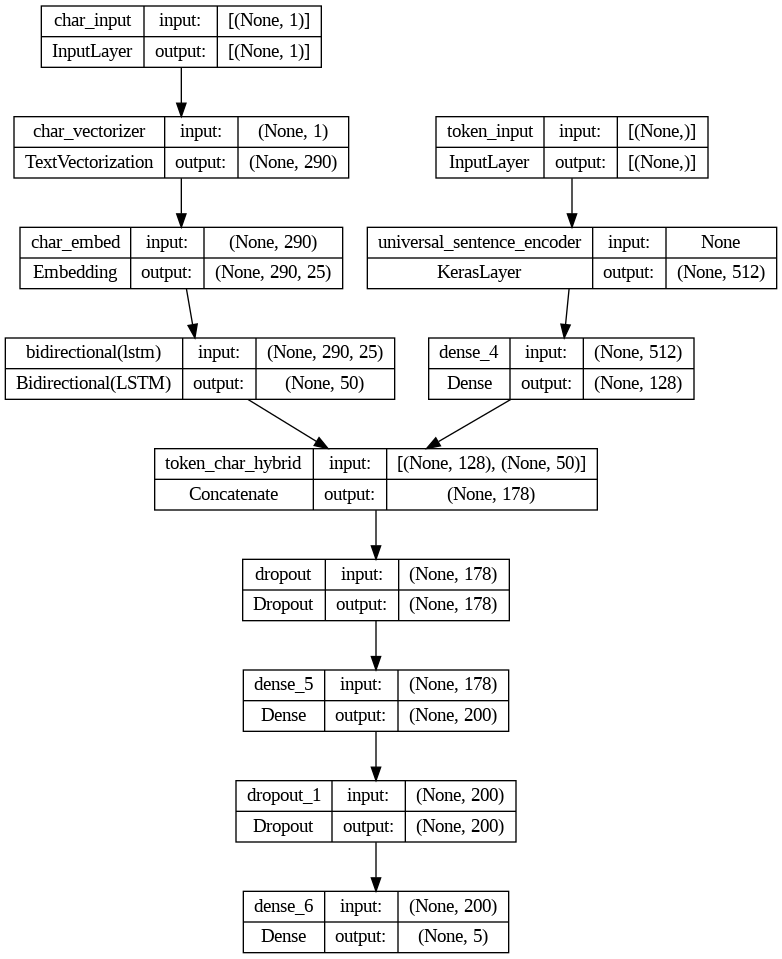

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data.Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,
                                                train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Do the same with validation set
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,
                                                val_char_token_labels))

# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# One more time with test set for later testing
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data,
                                              test_char_token_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Check out our training char-token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit model on tokens and char
model_history_4 = model_4.fit(train_char_token_dataset, epochs=5,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 37s 52ms/step - loss: 0.9581 - accuracy: 0.6208 - val_loss: 0.7708 - val_accuracy: 0.7058
Epoch 2/5
562/562 [==============================] - 27s 48ms/step - loss: 0.7845 - accuracy: 0.6969 - val_loss: 0.7119 - val_accuracy: 0.7264
Epoch 3/5
562/562 [==============================] - 25s 44ms/step - loss: 0.7598 - accuracy: 0.7098 - val_loss: 0.6843 - val_accuracy: 0.7354
Epoch 4/5
562/562 [==============================] - 28s 50ms/step - loss: 0.7367 - accuracy: 0.7216 - val_loss: 0.6690 - val_accuracy: 0.7483
Epoch 5/5
562/562 [==============================] - 26s 46ms/step - loss: 0.7375 - accuracy: 0.7170 - val_loss: 0.6577 - val_accuracy: 0.7467


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 23ms/step - loss: 0.6591 - accuracy: 0.7487


[0.6591280698776245, 0.7487091422080994]

In [ ]:
# Make predictions using the token-char hybrid model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 24s 23ms/step


array([[5.6816047e-01, 2.1806361e-01, 4.5722667e-03, 2.0053412e-01,
        8.6694788e-03],
       [3.8909033e-01, 4.6623772e-01, 5.8076810e-03, 1.3498223e-01,
        3.8820310e-03],
       [3.5267726e-01, 6.4507701e-02, 7.1236670e-02, 4.8316264e-01,
        2.8415712e-02],
       ...,
       [3.8982276e-04, 2.1066675e-03, 6.8999752e-02, 1.7308915e-04,
        9.2833072e-01],
       [3.0738176e-03, 1.9494906e-02, 3.5876501e-01, 1.4274567e-03,
        6.1723882e-01],
       [2.6217481e-01, 5.0145239e-01, 1.7708004e-01, 1.1327905e-02,
        4.7964826e-02]], dtype=float32)

In [ ]:
# Get results of token-char hybrid model
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 74.87091222030982,
 'precision': 0.7445399468463405,
 'recall': 0.7487091222030982,
 'f1': 0.7426884922758844}

# Model 5: Transfer Learning + Pretrained Token, Character and Positional Embeddings

>**Note:** Any engineered features (features derived from the data that are not explicitly listed as features already) used to train a model need to be available at test time

### Create Positional Embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

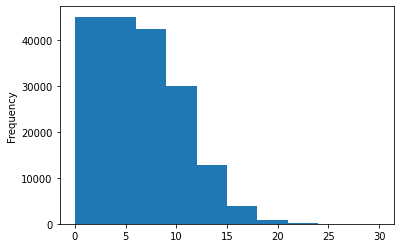

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist();

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:15], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
train_df.total_lines

0         11
1         11
2         11
3         11
4         11
          ..
180035    11
180036    11
180037    11
180038    11
180039    11
Name: total_lines, Length: 180040, dtype: int64

In [ ]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

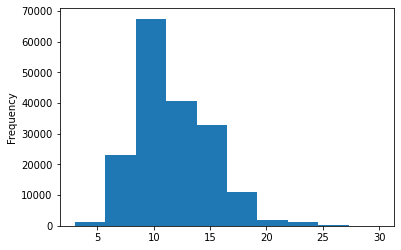

In [ ]:
# Check distribution of total lines
train_df.total_lines.plot.hist();

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 95), np.percentile(train_df.total_lines, 98)

(18.0, 20.0)

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:15]

<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

### Building a "Tribrid" Embedding Model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate` (hybrid 1)
6. Combine the ouputs of 3, 4, and 5 using `tf.keras.layers.Concatenate` (hybrid 2)
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the outputs of 1, 2, 3, 4 and outputs 7 into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. line_number feature model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. total_line feature model
total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_line_inputs)
total_lines_model = tf.keras.Model(inputs=total_line_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid")([token_model.output,
                                                                    char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token-char embeddings
z = layers.Concatenate(name="char_token_pos_embedding")([line_number_model.output,
                                                         total_lines_model.output,
                                                         z])
# 7. Create output layer
output_layer = layers.Dense(num_classes,
                            activation="softmax",
                            name="output_layer")(z)

# 8. Put together the model with all inputs combined
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

# Compile
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

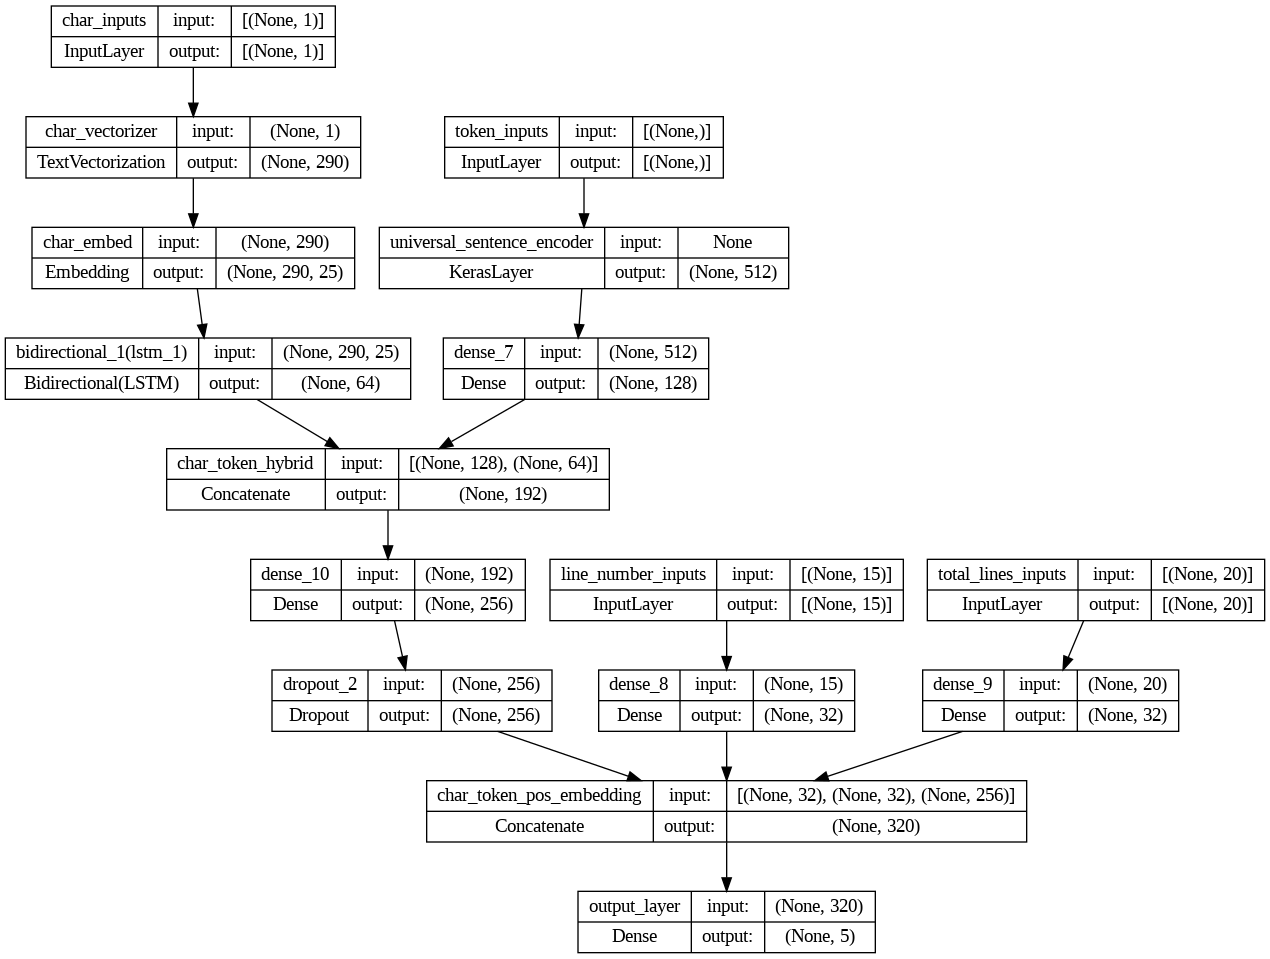

In [ ]:
# Plot model
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: 
`[0.0, 0.0, 1.0, 0.0, ... , 0.0]`

What label smoothing does it it assigns some of the value from the highest prediction probability (confidence) to other classes, in turn, hopefully improving generalization:

`[0.01, 0.01, 0.96, 0.01, ... , 0.01]`

> For a good reference on label smoothing, see the following blog post from PyImageSearch:
https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

### Create tribrid embedding datasets using `tf.data`

In [ ]:
# Create training and validation datasets (with all 4 kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                          train_total_lines_one_hot,
                                                          train_sentences,
                                                          train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,
                                                   train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat for validation set
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                          val_total_lines_one_hot,
                                                          val_sentences,
                                                          val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,
                                                   val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shape
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit and evaluate model_5
model_history_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=5,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 36s 52ms/step - loss: 1.1004 - accuracy: 0.7189 - val_loss: 0.9829 - val_accuracy: 0.8009
Epoch 2/5
562/562 [==============================] - 27s 47ms/step - loss: 0.9657 - accuracy: 0.8162 - val_loss: 0.9474 - val_accuracy: 0.8314
Epoch 3/5
562/562 [==============================] - 24s 43ms/step - loss: 0.9484 - accuracy: 0.8255 - val_loss: 0.9375 - val_accuracy: 0.8321
Epoch 4/5
562/562 [==============================] - 28s 50ms/step - loss: 0.9374 - accuracy: 0.8360 - val_loss: 0.9288 - val_accuracy: 0.8361
Epoch 5/5
562/562 [==============================] - 25s 45ms/step - loss: 0.9346 - accuracy: 0.8364 - val_loss: 0.9222 - val_accuracy: 0.8398


In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset,
                                     verbose=True)
model_5_pred_probs

945/945 [==============================] - 23s 22ms/step


array([[0.5763736 , 0.08672227, 0.01655003, 0.2950124 , 0.02534171],
       [0.6167493 , 0.07865535, 0.07681572, 0.21159133, 0.01618833],
       [0.36329037, 0.10155533, 0.11095102, 0.3784876 , 0.0457157 ],
       ...,
       [0.03376342, 0.06337988, 0.02747369, 0.02840837, 0.8469747 ],
       [0.02150687, 0.32932785, 0.10027897, 0.02492446, 0.5239619 ],
       [0.09319744, 0.71834326, 0.09211379, 0.02413311, 0.07221245]],
      dtype=float32)

In [ ]:
# Convert predictions to labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)
model_5_results

{'accuracy': 84.46643717728055,
 'precision': 0.8469377379045748,
 'recall': 0.8446643717728055,
 'f1': 0.8412494828093561}

In [ ]:
model_4_results

{'accuracy': 74.87091222030982,
 'precision': 0.7445399468463405,
 'recall': 0.7487091222030982,
 'f1': 0.7426884922758844}

In [ ]:
# Combine model results into a dataframe
all_results = pd.DataFrame({"model_0_baseline": baseline_results,
                            "model_1_custom_token_embedding": model_1_results,
                            "model_2_pretrained_token_embedding": model_2_results,
                            "model_3_custom_char_embedding": model_3_results,
                            "model_4_hybrid_char_token_embedding": model_4_results,
                            "model_5_token_char_pos_embedding": model_5_results})
all_results = all_results.transpose()
all_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,79.961605,0.799394,0.799616,0.796539
model_2_pretrained_token_embedding,73.427777,0.730132,0.734278,0.728351
model_3_custom_char_embedding,68.092149,0.685968,0.680921,0.678249
model_4_hybrid_char_token_embedding,74.870912,0.744540,0.748709,0.742688
model_5_token_char_pos_embedding,84.466437,0.846938,0.844664,0.841249


In [ ]:
# all_results["accuracy"] = all_results["accuracy"]/100

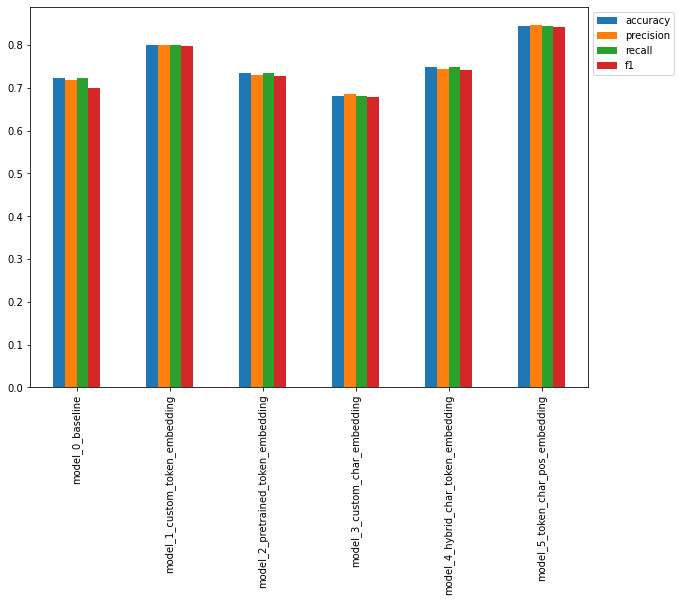

In [ ]:
# Plot and compare models
all_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

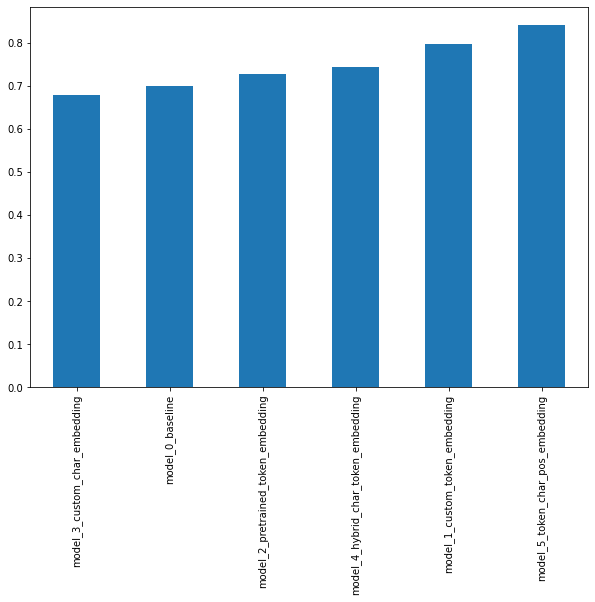

In [ ]:
# Sort model results by F1 score
all_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7))

## Save and Load Model

In [ ]:
# Save the best performing model to the SavedModel format
model_5.save("SkimLit_tribrid_model")

In [ ]:
# Load in a evaluate to confirm save-load
loaded_model_5 = tf.keras.models.load_model("SkimLit_tribrid_model")

In [ ]:
# Make predictions with loaded model
loaded_model_5_pred_probs = loaded_model_5.predict(val_char_token_pos_dataset)
loaded_model_5_preds = tf.argmax(loaded_model_5_pred_probs, axis=1)
loaded_model_5_preds[:10]

945/945 [==============================] - 26s 28ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate results
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_model_5_preds)
loaded_model_results

{'accuracy': 84.3009400238316,
 'precision': 0.8457340008649801,
 'recall': 0.8430094002383159,
 'f1': 0.83923208168557}

In [ ]:
model_5_results

{'accuracy': 84.3009400238316,
 'precision': 0.8457340008649801,
 'recall': 0.8430094002383159,
 'f1': 0.83923208168557}

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
loaded_model_5.summary()

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

## Download and Load in a Pretrained Model from Google Storage

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2023-01-30 21:12:43--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 2a00:1450:4013:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  30.4MB/s    in 26s     

2023-01-30 21:13:09 (35.0 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/k

In [ ]:
# Load in downloaded Google storage model
loaded_gs_model = tf.keras.models.load_model("/content/skimlit_gs_model/skimlit_tribrid_model/")

OSError: ignored

In [ ]:
# Evaluate loaded Google storage model
loaded_gs_model.evaluate(val_char_token_pos_dataset)

## Next Steps

1. Turn the test data samples into a tf.data.Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test samples.

2. Find the most wrong predictions from step 1 (the samples where the model has predicted the wrong label with the highest prediction probability/confidence).


In [ ]:
test_df

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17
30131,RESULTS,there were no statistically significant betwee...,14,17
30132,RESULTS,there was no significant association between s...,15,17
30133,RESULTS,no adverse effects were reported .,16,17


In [ ]:
# Step 1 - turn the test samples into a tf.data Dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,
                                                   test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_5_test_pred_probs = model_5.predict(test_char_token_pos_dataset)
model_5_test_pred_probs

942/942 [==============================] - 21s 22ms/step


array([[0.30007708, 0.08406889, 0.08140859, 0.44729477, 0.08715074],
       [0.2362105 , 0.04502078, 0.46098948, 0.20897637, 0.04880289],
       [0.05423542, 0.02378968, 0.8325276 , 0.06156825, 0.02787904],
       ...,
       [0.07239684, 0.11633459, 0.06557386, 0.05325394, 0.69244075],
       [0.06631566, 0.09082708, 0.11488348, 0.05704491, 0.6709289 ],
       [0.08840536, 0.47148603, 0.20605196, 0.05286583, 0.18119085]],
      dtype=float32)

In [ ]:
model_5_test_preds = tf.argmax(model_5_test_pred_probs, axis=1)
model_5_test_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [ ]:
# Step 2 - Find out where our model is the most wrong on the test data
test_pred_classes = [label_encoder.classes_[pred] for pred in model_5_test_preds]

test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(model_5_test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.447295,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.460989,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.832528,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.843912,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.722527,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.821398,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,METHODS,0.512982,False
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.453760,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.504739,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.616497,True


In [ ]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)

In [ ]:
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.964494,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.958887,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.956854,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.936760,False
22375,RESULTS,patients were randomly assigned to receive eit...,4,12,METHODS,0.936166,False
...,...,...,...,...,...,...,...
7066,RESULTS,generalized linear models indicated seeking sa...,2,5,METHODS,0.237139,False
19097,METHODS,the secondary purpose is to examine whether th...,6,12,CONCLUSIONS,0.236369,False
6117,BACKGROUND,we set out to determine the optimal intraopera...,7,16,OBJECTIVE,0.234135,False
7279,METHODS,we describe the rationale and design of the re...,3,7,CONCLUSIONS,0.233492,False


In [ ]:
# Step 3 - make predictions on some wild data
import json
import os

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-01-31 02:41:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-01-31 02:41:38 (56.3 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe("sentencizer")
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each abstracts lines and create dictionaries containing the necessary
# values for passing data to our model
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
# Get line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

# One-hot encode to same depth as training-validation sets so model accepts it
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers,
                                                 depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Do the same for total_lines
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines,
                                       depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
# Make predictions
%%time
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step
CPU times: user 2.41 s, sys: 45.4 ms, total: 2.46 s
Wall time: 2.43 s


array([[0.36884716, 0.09868176, 0.03846763, 0.44903207, 0.04497133],
       [0.05717824, 0.03005324, 0.77472484, 0.08138527, 0.05665841],
       [0.07032574, 0.03355999, 0.74278575, 0.10509159, 0.04823681],
       [0.08868474, 0.12227017, 0.5728535 , 0.0676995 , 0.14849208],
       [0.05257494, 0.11259083, 0.3497732 , 0.04844957, 0.4366115 ],
       [0.03806378, 0.10764934, 0.5764566 , 0.0411698 , 0.23666051],
       [0.02505601, 0.18456767, 0.06916305, 0.02512453, 0.6960887 ],
       [0.01576146, 0.13284957, 0.20672643, 0.02723987, 0.61742264]],
      dtype=float32)

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [ ]:
# Turn prediction class ints into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


In [ ]:
example_abstracts[0]

{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
 'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
 'details': 'RCT of a manualized 

## Further Exercises

1. Train `model_5` on *all* of the training dataset with `ModelCheckpoint` and `EarlyStopping` callbacks worked in.

In [ ]:
# Create a checkpoint callback instance and ckpt file for storing weights
checkpoint_path = "model_checkpoints/cp.ckpt" # save weights when training stops
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

# Create EarlyStopping callback for if model stops improving
early_stopping_cb =tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                    patience=3)

# Recompile model_5
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_model_5_full = model_5.fit(train_char_token_pos_dataset, epochs=50,
                                   steps_per_epoch=len(train_char_token_pos_dataset),
                                   validation_data=val_char_token_pos_dataset,
                                   validation_steps=int(0.2*len(val_char_token_pos_dataset)),
                                   callbacks=[model_checkpoint,
                                              early_stopping_cb])

Epoch 1/50
5627/5627 [==============================] - 279s 48ms/step - loss: 0.3917 - accuracy: 0.8526 - val_loss: 0.3577 - val_accuracy: 0.8601
Epoch 2/50
5627/5627 [==============================] - 279s 50ms/step - loss: 0.3497 - accuracy: 0.8685 - val_loss: 0.3455 - val_accuracy: 0.8651
Epoch 3/50
5627/5627 [==============================] - 334s 59ms/step - loss: 0.3274 - accuracy: 0.8772 - val_loss: 0.3413 - val_accuracy: 0.8662
Epoch 4/50
5627/5627 [==============================] - 259s 46ms/step - loss: 0.3112 - accuracy: 0.8838 - val_loss: 0.3391 - val_accuracy: 0.8679
Epoch 5/50
5627/5627 [==============================] - 260s 46ms/step - loss: 0.2971 - accuracy: 0.8885 - val_loss: 0.3423 - val_accuracy: 0.8727
Epoch 6/50
5627/5627 [==============================] - 291s 52ms/step - loss: 0.2849 - accuracy: 0.8929 - val_loss: 0.3497 - val_accuracy: 0.8700
Epoch 7/50
5627/5627 [==============================] - 275s 49ms/step - loss: 0.2748 - accuracy: 0.8968 - val_loss: 0

2. Try incorporating a GloVe embedding into one of our models using Keras.

*Following along with Keras documentation from the following link: https://keras.io/examples/nlp/pretrained_word_embeddings/*

In [ ]:
# Download pre-trained GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-01-31 04:04:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-31 04:04:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-31 04:04:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Make a dict mapping words (strings) to their numpy vector representation
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Prepare a corresponding embedding matrix to be used in embedding layer
new_output_seq_len = 100
max_tokens = 68000

# New TextVectorizer instance
token_vectorizer_2 = TextVectorization(max_tokens=max_tokens,
                                       output_sequence_length=new_output_seq_len)
token_vectorizer_2.adapt(train_sentences)

# Get vocabulary
new_rct_20k_text_vocab = token_vectorizer_2.get_vocabulary()
word_index = dict(zip(new_rct_20k_text_vocab, range(len(new_rct_20k_text_vocab))))

In [ ]:
# Prepare embedding matrix
embedding_matrix = np.zeros((len(new_rct_20k_text_vocab), new_output_seq_len))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # Words not found in embedding index will be all-zeros.
    # This includes the representation for "padding" and "OOV"
    embedding_matrix[i] = embedding_vector

In [ ]:
# Create a new custom embedding layer
new_token_embed = layers.Embedding(input_dim=len(new_rct_20k_text_vocab),
                                   output_dim=100,
                                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                   mask_zero=True,
                                   # trainable=False,
                                   name="new_token_embedding")

In [ ]:
# Recreate model_5 as `model_6` with new custom embedding layer to test
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = new_token_embed(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32,
                                  name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32,
                                 name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_line_inputs)
total_lines_model = tf.keras.Model(inputs=total_line_inputs,
                                   outputs=y)

combined_embeddings = layers.Concatenate(name="char_token_hybrid")([token_model.output,
                                                                    char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)
z = layers.Concatenate(name="char_token_pos_embedding")([line_number_model.output,
                                                         total_lines_model.output,
                                                         z])
output_layer = layers.Dense(num_classes,
                            activation="softmax",
                            name="output_layer")(z)

model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

# Compile and summarize
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

TypeError: ignored

In [ ]:
history_model_6 = model_6.fit(train_char_token_pos_dataset, epochs=5,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

*Potential next steps:* Replace the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the TensorFlow Hub BERT PubMed expert pretrained embedding and see if results can be improved.

In [ ]:
# Create a BERT layer from TF Hub
tf_hub_bert_layer = hub.KerasLayer("https://tfhub.dev/google/experts/bert/pubmed/2",
                                                         trainable=False,
                                                         name="pubmed_bert")